# **Marketing Campaign Analysis**

## **Import the necessary libraries and load the data**

In [251]:
!pip install scikit-learn-extra

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Overview**

In [254]:
# Reading the dataset
data = pd.read_csv("/content/drive/MyDrive/marketing_campaign.csv")

In [255]:
# Copy the dataset
df = data.copy()

In [256]:
# Understanding the shape of the dataset
df.shape

(2240, 27)

In [257]:
# First 3 rows
df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,2,10,4,0,0,0,0,0,0,0


In [258]:
# Last 3 rows
df.tail(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,3,13,6,0,1,0,0,0,0,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,5,10,3,0,0,0,0,0,0,0
2239,9405,1954,PhD,Married,52869.0,1,1,15-10-2012,40,84,...,1,4,7,0,0,0,0,0,0,1


In [259]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

#### **Observations and Insights:**

**Data types**:
  - 24 numerical columns: 1 float column (`Income`) and 23 integer columns.
  - 3 categorical columns: `Education`, `Marital_Status`, `Dt_Customer`.

**Missing values**:
  - All columns have 2240 non-null entries, except `Income` which has 2216 non-null entries (24 missing values).

In [260]:
# Find the percentage of missing values, display only columns with missing values
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
missing_percentage

,0
Income,1.071429


#### **Observations and Insights:**

The `Income` column has 1.07% missing values (24 out of 2240 rows). Since the percentage of missing values is small, we can later impute the missing values with the median. This approach preserves the data while avoiding any bias caused by outliers, as the median is a robust statistic.

In [261]:
# Checking the count of unique values in each column
df.nunique()

,0
ID,2240
Year_Birth,59
Education,5
Marital_Status,8
Income,1974
Kidhome,3
Teenhome,3
Dt_Customer,663
Recency,100
MntWines,776


In [262]:
# Checking for duplicates in the dataset
df.duplicated().sum()

0

In [263]:
# Drop ID column
# All ID values are unique, this means having it as a separate column might be redundant
df.drop(['ID'], axis=1, inplace=True)

## **Exploratory Data Analysis (EDA)**


In [264]:
# Statistical summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0


In [265]:
# Categorical columns in the data
cols = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Complain']

for column in cols:
  print(column, ":", df[column].unique())
  print("-" * 100)

Education : ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
----------------------------------------------------------------------------------------------------
Marital_Status : ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
----------------------------------------------------------------------------------------------------
Kidhome : [0 1 2]
----------------------------------------------------------------------------------------------------
Teenhome : [0 1 2]
----------------------------------------------------------------------------------------------------
Complain : [0 1]
----------------------------------------------------------------------------------------------------


#### **Observations and Insights:**

- The `Education` column contains categories representing different educational levels. `2n Cycle` likely refers to a post-graduate degree, similar to a `Master`. Since both represent advanced education levels, combining them simplifies the data without losing meaning.

- `Marital_Status` includes valid categories like `Single`, `Married`, `Divorced`, and `Widow`, but also contains errors or sarcastic entries like `Absurd` and `YOLO`. `Single` and `Alone` both refer to individuals not in a relationship, so they can be merged into `Single` for simplicity. `Together` and `Married` both imply being in a relationship, so they should be combined into `Married`. `Absurd` and `YOLO` are not valid marital statuses and should be replaced with `Unknown` to clean the data.

- `Kidhome` represents the number of children in a household, with values ranging from 0 to 2. Similar to `Kidhome`, `Teenhome` represents the number of teenagers in the household, also ranging from 0 to 2.

- `Complain` is a binary column indicating whether the customer has made a complaint (0 for no, 1 for yes).

In [266]:
# Combining categories and renaming
# '2n Cycle' -> 'Master'
df['Education'].replace({'2n Cycle': 'Master'}, inplace=True)

# 'Alone' -> 'Single'
df['Marital_Status'].replace({'Alone': 'Single'}, inplace=True)

# 'Together' -> 'Married'
df['Marital_Status'].replace({'Together': 'Married'}, inplace=True)

# 'Absurd', 'YOLO' -> 'Unknown'
df['Marital_Status'].replace({'Absurd': 'Unknown', 'YOLO': 'Unknown'}, inplace=True)

In [267]:
# Value proportions in every column
for column in cols:
  # Calculate, round, and format the percentage of each unique value in the column
  percentages = (df[column].value_counts(normalize=True) * 100).round(1).astype(str) + '%'
  print(percentages)
  print("-" * 50)

Education
Graduation    50.3%
Master        25.6%
PhD           21.7%
Basic          2.4%
Name: proportion, dtype: object
--------------------------------------------------
Marital_Status
Married     64.5%
Single      21.6%
Divorced    10.4%
Widow        3.4%
Unknown      0.2%
Name: proportion, dtype: object
--------------------------------------------------
Kidhome
0    57.7%
1    40.1%
2     2.1%
Name: proportion, dtype: object
--------------------------------------------------
Teenhome
0    51.7%
1    46.0%
2     2.3%
Name: proportion, dtype: object
--------------------------------------------------
Complain
0    99.1%
1     0.9%
Name: proportion, dtype: object
--------------------------------------------------


### **Univariate Analysis on Numerical and Categorical data**


In [268]:
# Function that plots a boxplot and a histogram along the same scale for all numerical values
def histogram_boxplot(feature):
  fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': (1,3)}, figsize=(12,5))
  sns.boxplot(data=df, x=feature, showmeans= True, color='pink', ax=ax[0])
  sns.histplot(data=df, x=feature, kde=True, ax=ax[1])
  ax[1].axvline(df[feature].mean(), color='green', linestyle='--')
  ax[1].axvline(df[feature].median(), color='red', linestyle='-.')

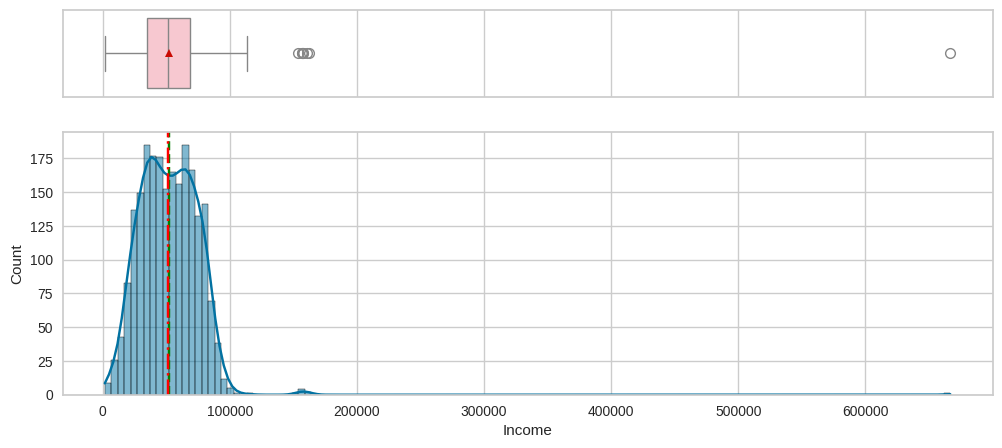

In [269]:
# Plot for `Income`
histogram_boxplot('Income')

#### **Observations and Insights:**

- The histogram and box plot suggest that the `Income` variable has a **right-skewed distribution**, with most individuals earning lower incomes, while a smaller group of individuals have very high incomes. This is evident from the longer tail on the right side of the distribution.
- The extreme values (**outliers**) on the higher end indicate that there are a few individuals with significantly higher incomes. These outliers could represent high-net-worth individuals or errors in data entry. To determine whether to treat them as outliers, we can use the **IQR (Interquartile Range) method** to check if they lie beyond the acceptable range.

In [270]:
# Formula to calculate IQR: q3 - q1
q1 = df['Income'].quantile(0.25)
q3 = df['Income'].quantile(0.75)
iqr = q3 - q1
print("Q1:", q1, "Q3:", q3, "IQR:", iqr)

# Formula to calculate upper whisker: q3 + 1.5 * IQR
whisker = q3 + 1.5 + iqr
print("Upper whisker:", whisker)

Q1: 35303.0 Q3: 68522.0 IQR: 33219.0
Upper whisker: 101742.5


In [271]:
# Show outliers
outliers = df[df['Income'] > whisker].index
outliers

Index([124, 164, 203, 252, 617, 646, 655, 687, 1300, 1653, 1898, 2132, 2233], dtype='int64')

Only 13 rows determined as outliers using IQR.

In [272]:
# Drop the outliers
df.drop(index=outliers, inplace=True)

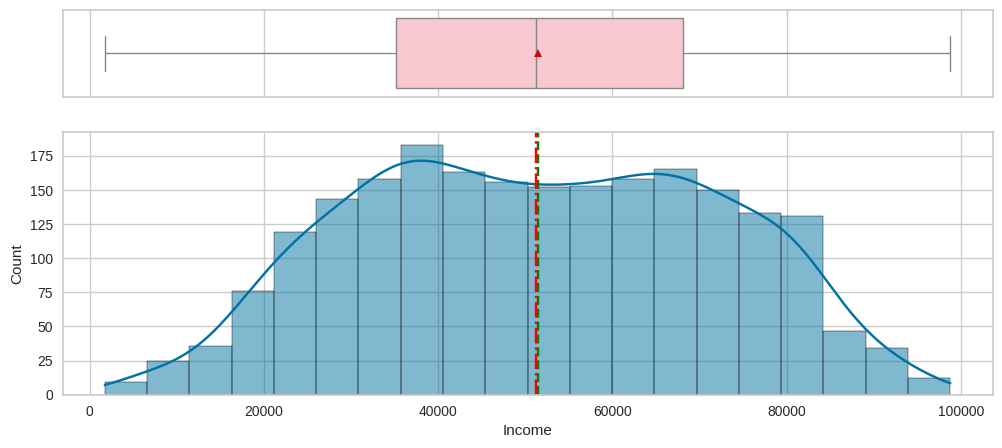

In [273]:
# Plot for `Income` without outliers
histogram_boxplot('Income')

<Figure size 2000x500 with 0 Axes>

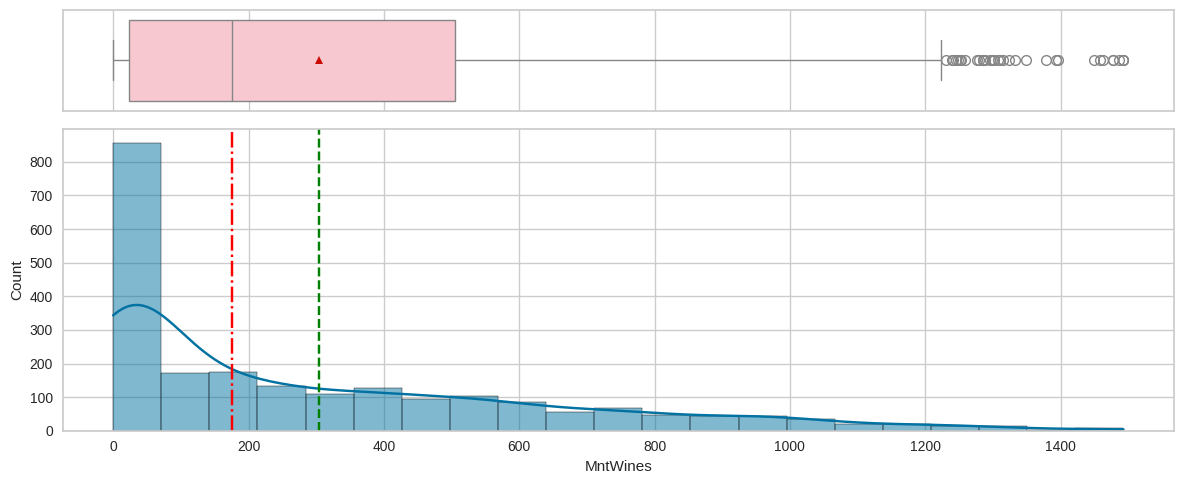

<Figure size 2000x500 with 0 Axes>

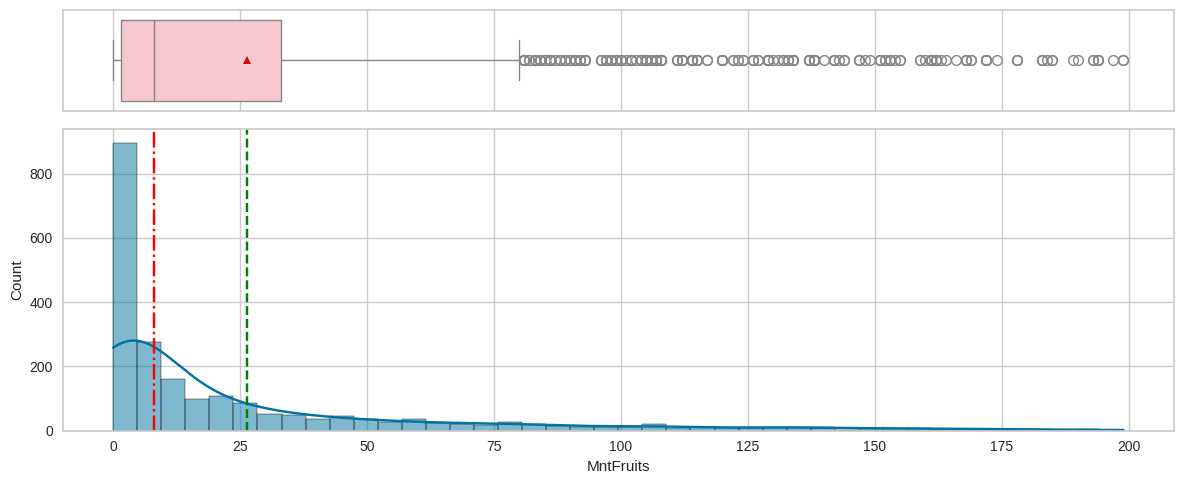

<Figure size 2000x500 with 0 Axes>

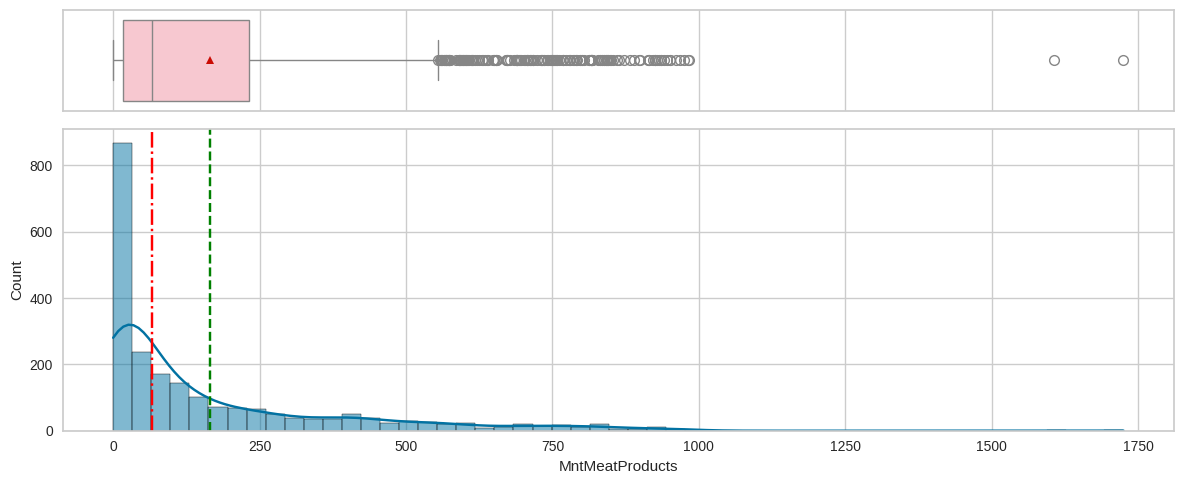

<Figure size 2000x500 with 0 Axes>

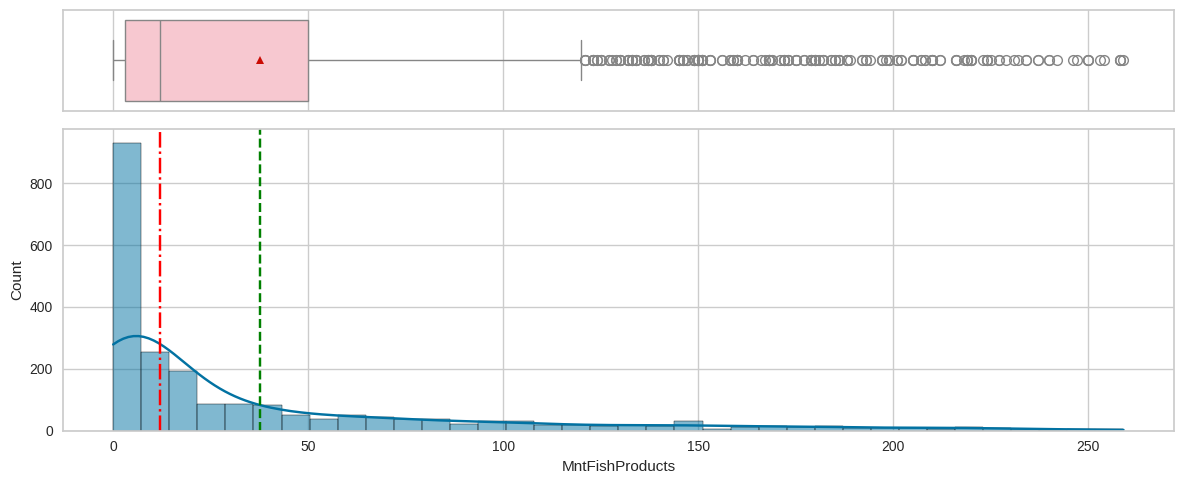

<Figure size 2000x500 with 0 Axes>

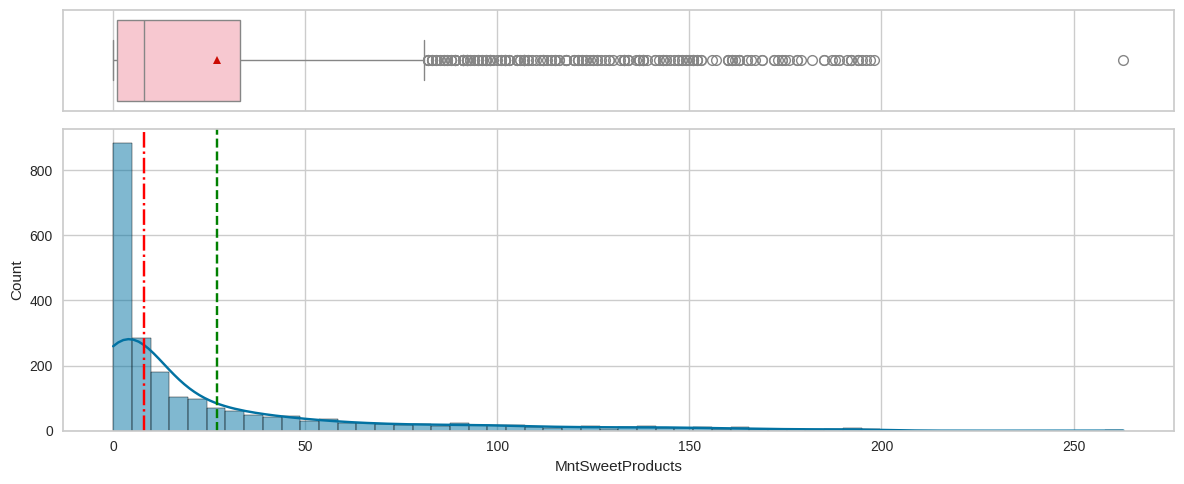

<Figure size 2000x500 with 0 Axes>

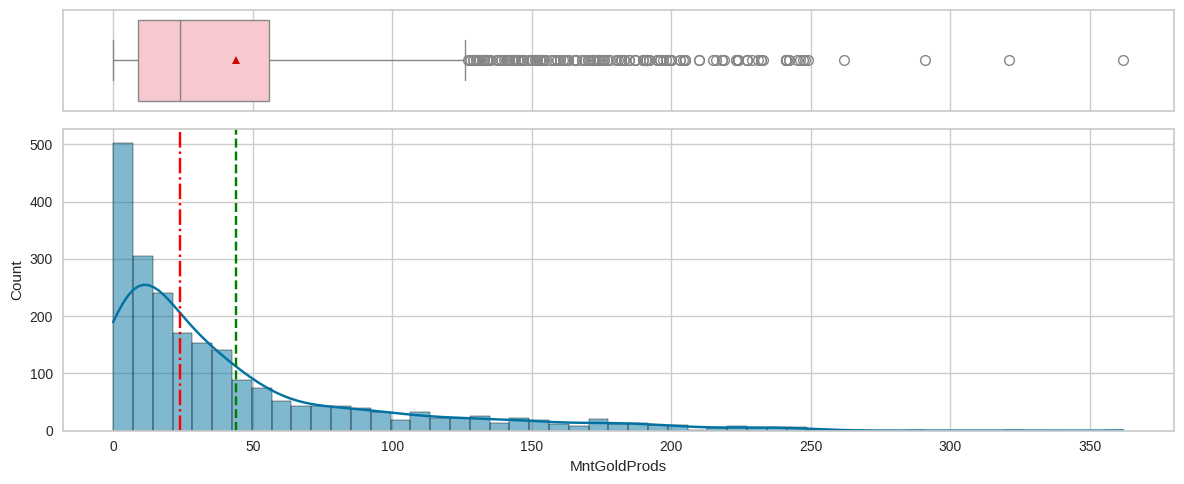

In [274]:
# Plot the boxplots and histograms for Spending Behavior (Last 2 Years) on fish products, meat products, fruits, sweets, wine, gold products
features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

for feature in features:
  plt.figure(figsize=(20, 5))
  histogram_boxplot(feature)
  plt.tight_layout()
  plt.show()

#### **Observations and Insights for all the plots:**

Overall Distribution:
- Most spending features, such as MntWines, MntMeatProducts, and MntFishProducts, exhibit **right-skewed distributions** with a few customers spending significantly higher amounts than the majority.
- These outliers indicate that only a small subset of customers contribute disproportionately to spending on specific categories.

Category Popularity:
- **Wines** category shows the **highest overall spending** among customers, indicating wine is the **most popular product**.
- **Meat products** are the second most purchased, with spending levels slightly below that of wines.
- Spending on **fruits, fish products and sweets** is significantly lower compared to wines and meat, suggesting they may be **supplementary products**.
- Spending on **gold products** is the lowest, indicating it is a **niche category**.

Boxplot Observations:
- Each feature shows a **long upper whisker**, confirming the presence of **high-spending outliers**.
- The interquartile range (IQR) is narrow for lower spending categories (MntSweetProducts, MntGoldProds), reflecting **limited variation among most customers**.

Insights on Marketing Strategy:
- The high-spending outliers in categories like `MntWines` and `MntMeatProducts` could represent loyal or premium customers who can be **targeted** for **exclusive offers** or **loyalty programs**.
- Campaigns could be designed to **boost engagement** for less popular categories such as gold products or sweets to improve sales in these segments.
- The clear differences in spending habits suggest potential for **segmentation based on preferences** (e.g. wine lovers, budget-conscious shoppers, premium spenders).



In [275]:
# Function to plot a bar chart with percentages for a categorical feature
def bar_plot_categorical(feature, ax):
    total = len(df[feature])
    sns.countplot(data=df, x=feature, palette='pastel', order=df[feature].value_counts().index, ax=ax)

    # Calculate percentage for each category
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center')

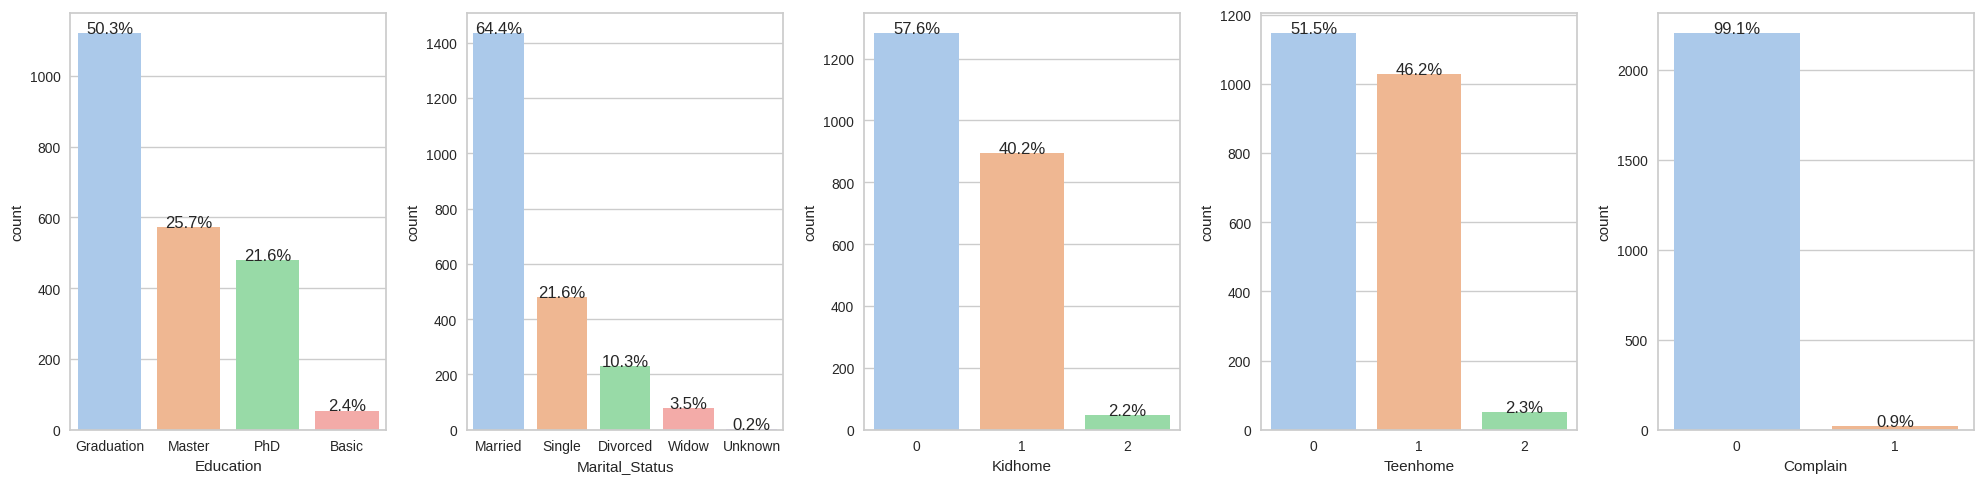

In [276]:
# List of features to plot
features = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Complain']
fig, axes = plt.subplots(1, len(features), figsize=(20, 5))

# Loop through each feature and plot on respective subplot
for i, feature in enumerate(features):
    bar_plot_categorical(feature, axes[i])

plt.tight_layout()
plt.show()

#### **Observations and Insights from all plots:**

- The majority of customers are Graduates (50.3%), followed by Masters (25.7%) and PhDs (21.6%). This indicates a **highly educated** customer base, ideal for higher-value or specialised product offerings. A small portion has Basic education (2.4%), suggesting an untapped segment for simpler, more accessible products.
- Most customers are Married (64.4%), indicating a strong market for **family-oriented** products. Singles (21.6%) may respond better to **individual-focused** offerings, while the smaller Divorced (10.3%) and Widowed (3.5%) groups could benefit from **personalized services addressing life stages**.
- Over half of customers have no children (57.6%), which may indicate **higher disposable income** for luxury or experience-based products. 40.2% have one child, a key segment for **family products**, while 2.2% with two children are ideal candidates for family packages or discounts.
- 51.5% of customers have no teenagers, while 46.2% have one. Products targeting this group could include fashion, tech, or educational services. The small 2.3% with two teenagers might be suited for family-centric offers or **multi-child discounts**.
- Only 0.9% of customers have complained in the past two years, reflecting **high satisfaction**. This provides an opportunity to emphasise customer satisfaction in marketing campaigns, focusing on **trust and quality**.

Insights on Marketing Strategy:
- Leverage the large educated customer base with **high-value, specialized products**.
- Focus on Married customers for **family-oriented products**, while appealing to Singles with **individual-focused offerings**.
- Target families with one or two children with tailored **family packages or discounts**.
- Highlight the low complaint rate to **promote customer satisfaction and brand reliability**.

### **Bivariate Analysis**

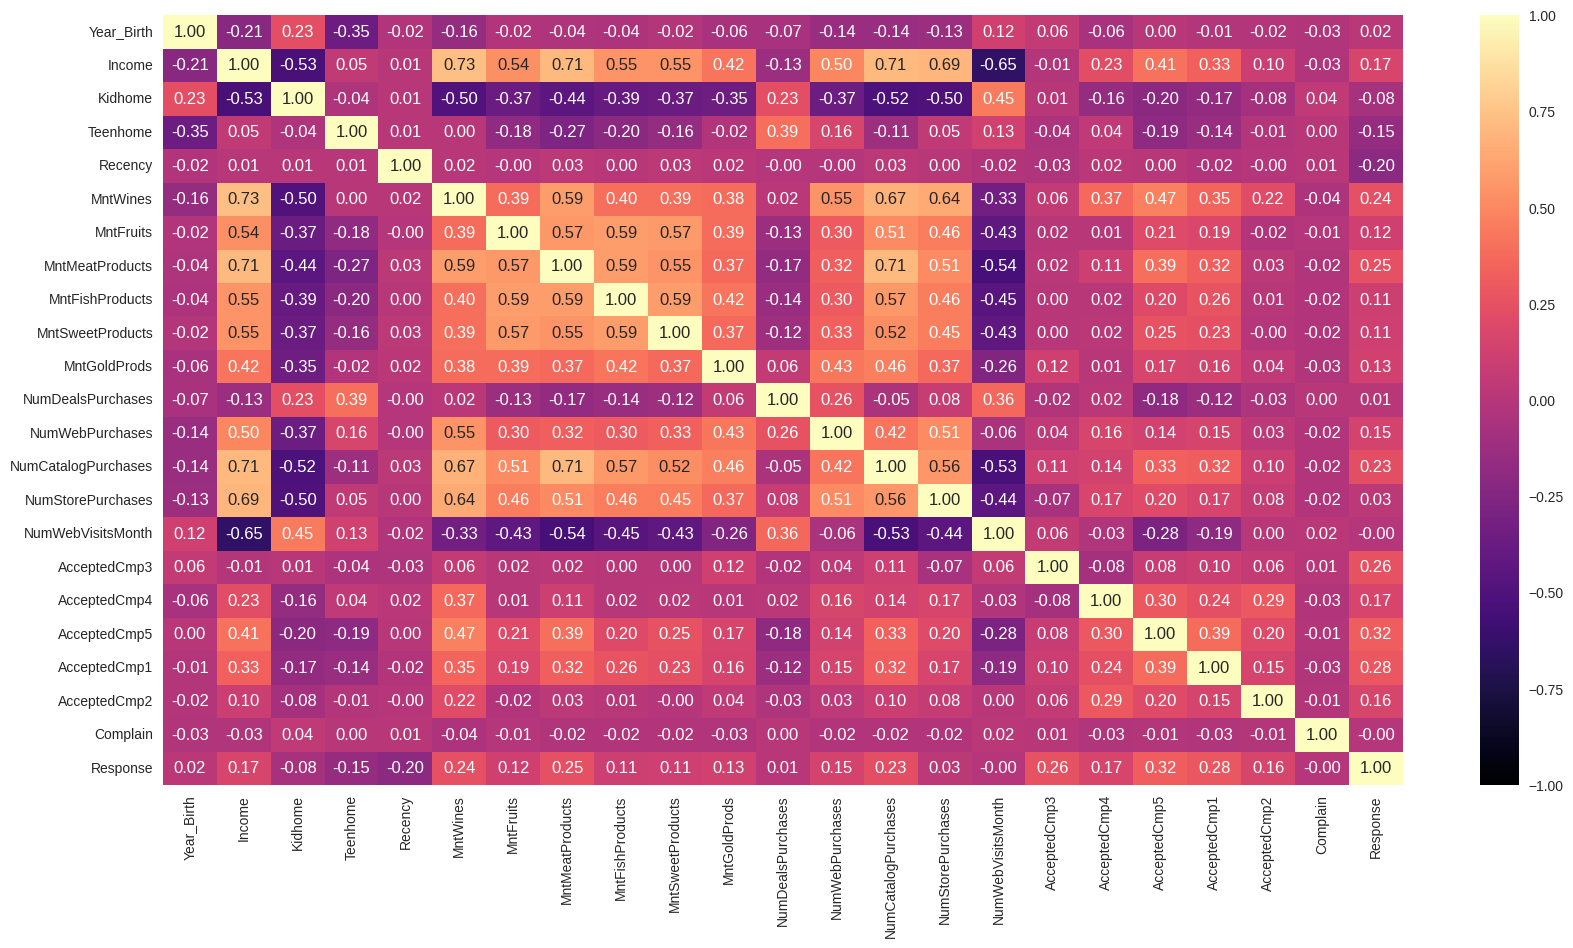

In [277]:
# Filter numerical columns
numerical_cols = df.select_dtypes(include = np.number).columns

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data=df[numerical_cols].corr(), annot=True, cmap='magma', vmin=-1, vmax=1, fmt = ".2f")
plt.show()

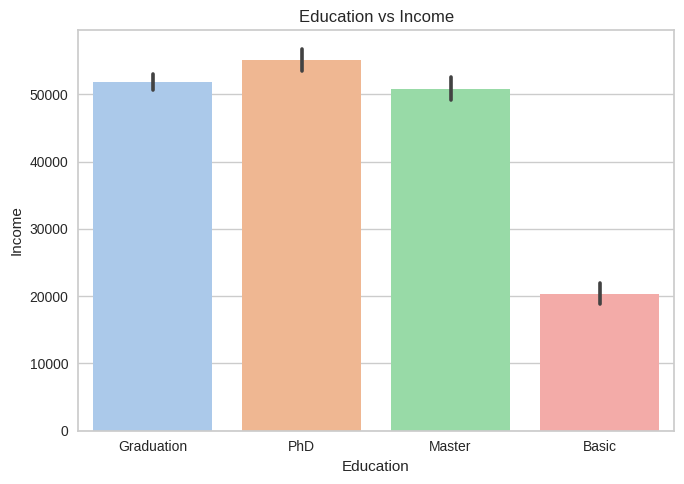

In [278]:
# Education vs Income
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='Education', y='Income', palette='pastel')
plt.title('Education vs Income')
plt.xlabel('Education')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

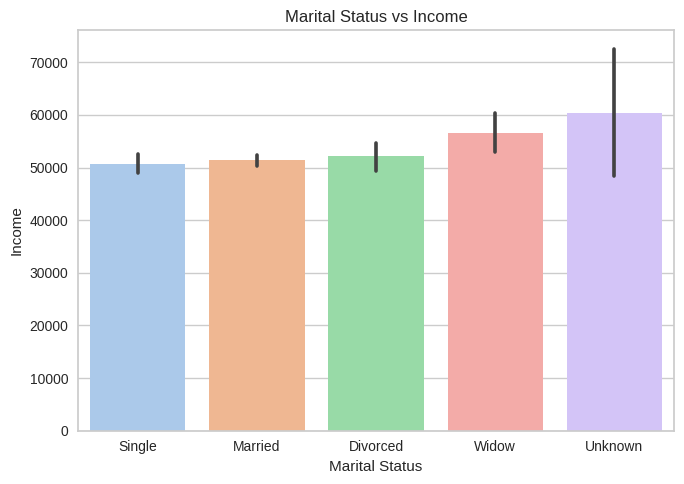

In [279]:
# Marital Status vs Income
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='Marital_Status', y='Income', palette='pastel')
plt.title('Marital Status vs Income')
plt.xlabel('Marital Status')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

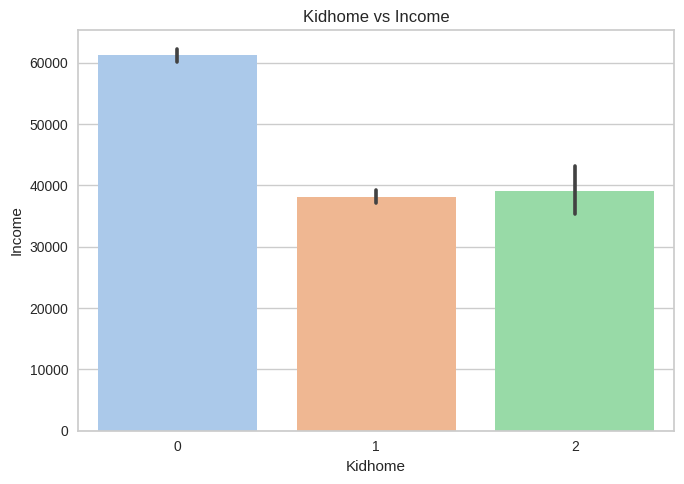

In [280]:
# Kidhome vs Income
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='Kidhome', y='Income', palette='pastel')
plt.title('Kidhome vs Income')
plt.xlabel('Kidhome')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

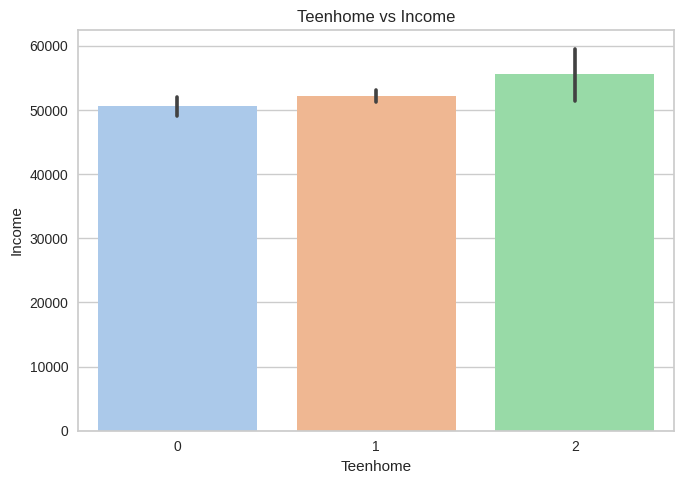

In [281]:
# Teenhome vs Income
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='Teenhome', y='Income', palette='pastel')
plt.title('Teenhome vs Income')
plt.xlabel('Teenhome')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

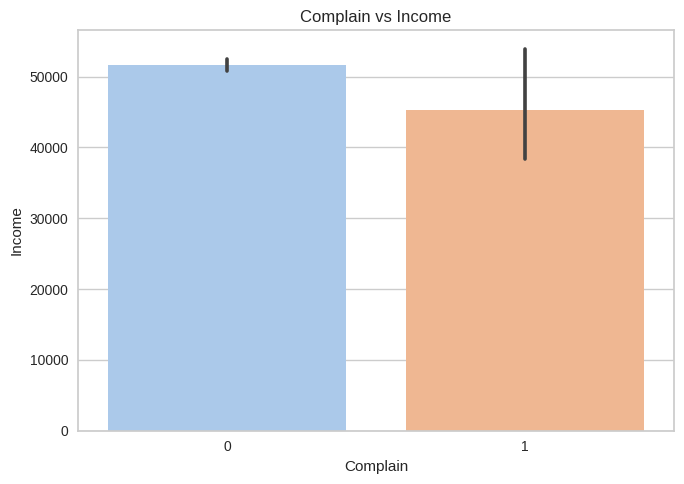

In [282]:
# Complain vs Income
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x='Complain', y='Income', palette='pastel')
plt.title('Complain vs Income')
plt.xlabel('Complain')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

<Figure size 700x500 with 0 Axes>

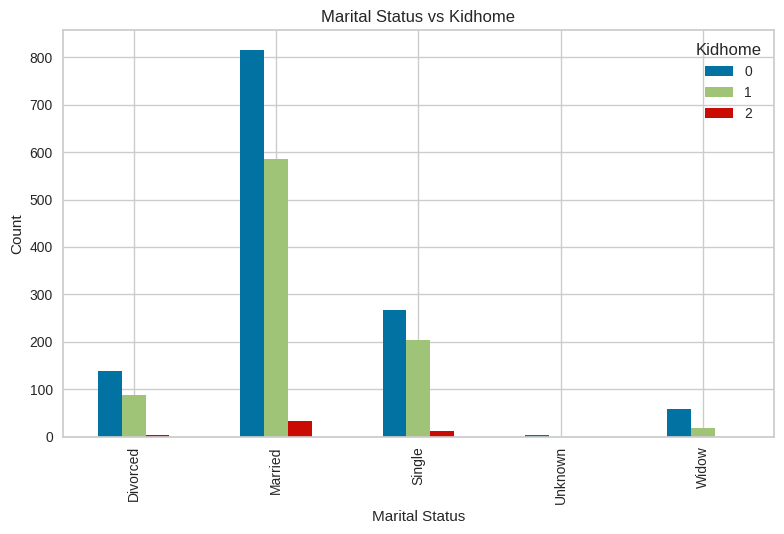

In [283]:
# Marital Status vs Kidhome
plt.figure(figsize=(7, 5))
pd.crosstab(df['Marital_Status'], df['Kidhome']).plot(kind='bar', stacked=False)
plt.title('Marital Status vs Kidhome')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

<Figure size 700x500 with 0 Axes>

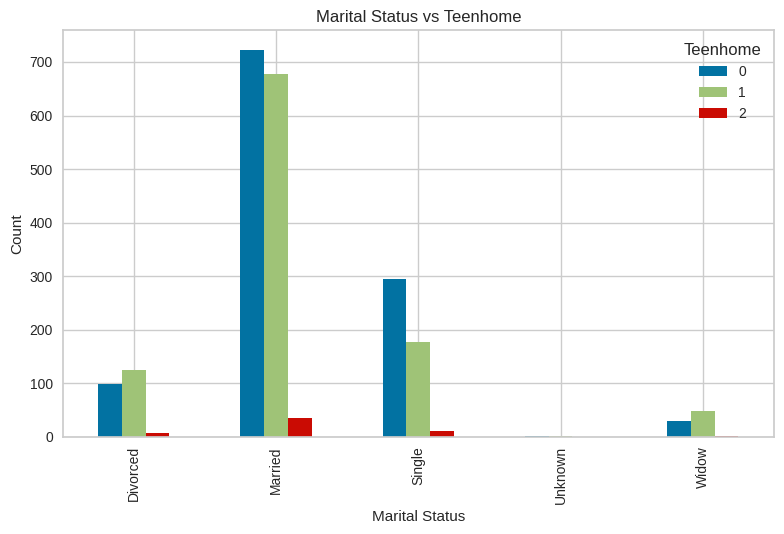

In [284]:
# Marital Status vs Teenhome
plt.figure(figsize=(7, 5))
pd.crosstab(df['Marital_Status'], df['Teenhome']).plot(kind='bar', stacked=False)
plt.title('Marital Status vs Teenhome')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### **Observations and Insights:**



## **Feature Engineering and Data Processing**


**Age range**

In [285]:
# We assume that the data is collected in the year 2016.
# Extract only the year from the Year_Birth variable and subtracting it from 2016 will give us the age of the customer at the time of data collection in 2016
df['Age'] = 2016 - pd.to_datetime(df['Year_Birth'], format="%Y").apply(lambda x: x.year)

# Sorting the values in ascending order
df['Age'].sort_values()

,Age
46,20
1170,20
995,21
1850,21
747,21
...,...
424,75
1950,76
192,116
339,117


The youngest customer is 20 years old. The oldest customer is 123 years old, which seems unrealistic and **may be an error**. Ages above 115 are likely incorrect, and we will **remove these outliers** from the dataset.

In [286]:
# Drop rows where Age is greater than 115
df.drop(df[df['Age'] > 115].index, inplace=True)

In [287]:
# Now we can drop 'Year_Birth' variable as it is excessive
df.drop(['Year_Birth'], axis=1, inplace=True)

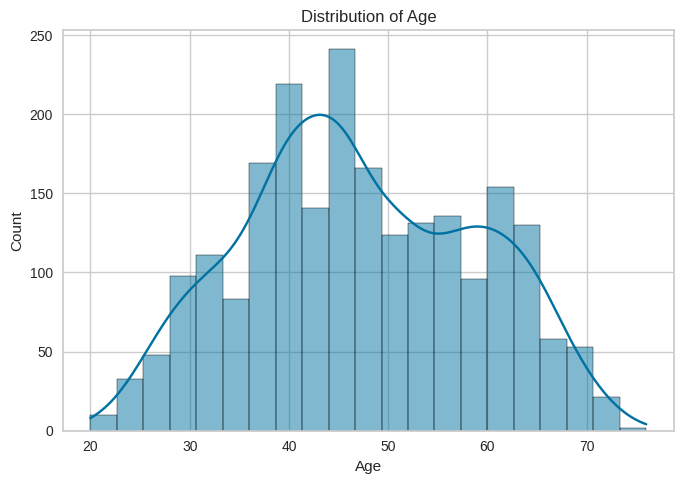

In [288]:
# Plot histogram to check the distribution of age
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='Age', kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### **Observations and Insights:**



**Size of a family and number of kids**

In [289]:
# Create feature 'Kids' indicating both kids and teens at home
df['Kids'] = df['Kidhome'] + df['Teenhome']

In [290]:
# Now we can drop 'Kidhome' and 'Teenhome' variables as they are excessive
df.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

In [291]:
# Create the 'FamilySize' variable based on marital status with the conditions
df['FamilySize'] = np.where(
  df['Marital_Status'].isin(['Single', 'Divorced', 'Widow', 'Unknown']),
  # If not married, assume 1 person
  df['Kids'] + 1,
  # If married, assume 2 people
  df['Kids'] + 2
)

**Customer engagement period**

In [292]:
# Ensure the 'Dt_Customer' column is in datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

# Sort the 'Dt_Customer' column in ascending order
df['Dt_Customer'].sort_values()


,Dt_Customer
1255,2012-07-30
1363,2012-07-31
976,2012-08-01
724,2012-08-01
2029,2012-08-01
...,...
796,2014-06-28
1812,2014-06-28
45,2014-06-28
200,2014-06-29


In [293]:
# Create the 'DaysWithCompany' variable which indicates how long customer has been with the company
# We use start of 2016 as a threshold
df['DaysWithCompany'] = (pd.to_datetime('2016-01-01') - df['Dt_Customer']).dt.days

In [294]:
# Now we can drop 'Dt_Customer' variable as it is excessive
df.drop(['Dt_Customer'], axis=1, inplace=True)

**Expenses and number of purchases**

In [295]:
# Create the 'TotalExpenses' variable which indicates total spendings over 2 years by customers
df['TotalExpenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

In [296]:
# Create the 'TotalNumPurchases' variable which indicates total number of purchases by each customer
df['TotalNumPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [297]:
# Create the 'ExpensePerPurchase' variable which indicates amount spent per purchase
df['ExpensePerPurchase'] = df['TotalExpenses'] / df['TotalNumPurchases']

# Sort the 'ExpensePerPurchase' column in ascending order
df['ExpensePerPurchase'].sort_values()

,ExpensePerPurchase
1245,0.533333
1846,0.600000
2129,2.000000
1420,2.000000
1819,2.250000
...,...
644,173.230769
1328,186.500000
2228,1679.000000
1524,inf


Some values in the `ExpensePerPurchase` column are `inf` (infinity), which typically occurs when TotalNumPurchases is 0 (i.e., customers who have not made any purchases but have recorded expenses).We need to drop or handle rows with `inf` values to **avoid skewing the analysis**.

In [298]:
# Find how many observations have NumTotalPurchases equal to 0
df[df['TotalNumPurchases'] == 0]['ExpensePerPurchase'].value_counts()

# Drop those observations
df.drop(df[df['TotalNumPurchases'] == 0].index, inplace=True)

In [299]:
# Summary statistics for ExpensePerPurchase
df['ExpensePerPurchase'].describe()

,ExpensePerPurchase
count,2222.000000
mean,33.261026
std,45.084449
min,0.533333
25%,9.703571
50%,23.314732
75%,45.185102
max,1679.000000


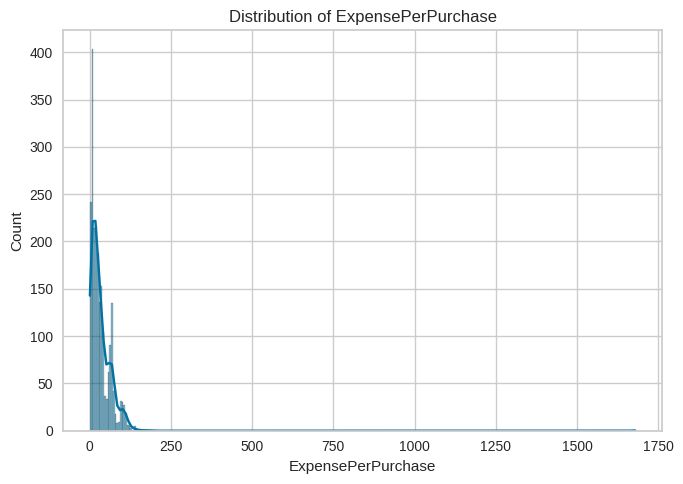

In [300]:
# Plot histogram to check the distribution of ExpensePerPurchase
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='ExpensePerPurchase', kde=True)
plt.title('Distribution of ExpensePerPurchase')
plt.xlabel('ExpensePerPurchase')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Most data points are clustered on the lower end of the histogram, which indicates that most customers are spending relatively low amounts per purchase. This suggests that the **average spending** per purchase is heavily **influenced by the majority** of customers, making it less representative of high-spending outliers.

**Offer Acceptance**

In [301]:
# Create the 'TotalAcceptedOffers' variable which indicates the total number of accepted campaigns by a customer
df['TotalAcceptedOffers'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4' ]+ df['AcceptedCmp5'] + df['Response']

In [302]:
# Now we can drop 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response' variables as they are excessive
df.drop(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'], axis=1, inplace=True)

In [303]:
df.head().T

,0,1,2,3,4
Education,Graduation,Graduation,Graduation,Graduation,PhD
Marital_Status,Single,Single,Married,Married,Married
Income,58138.0,46344.0,71613.0,26646.0,58293.0
Recency,58,38,26,26,94
MntWines,635,11,426,11,173
MntFruits,88,1,49,4,43
MntMeatProducts,546,6,127,20,118
MntFishProducts,172,2,111,10,46
MntSweetProducts,88,1,21,3,27
MntGoldProds,88,6,42,5,15


**Impute Missing Values**

In [304]:
# Impute the missing values for the `Income` variable with the median
df['Income'] = df['Income'].fillna(df['Income'].median())

**Income vs Expenses**

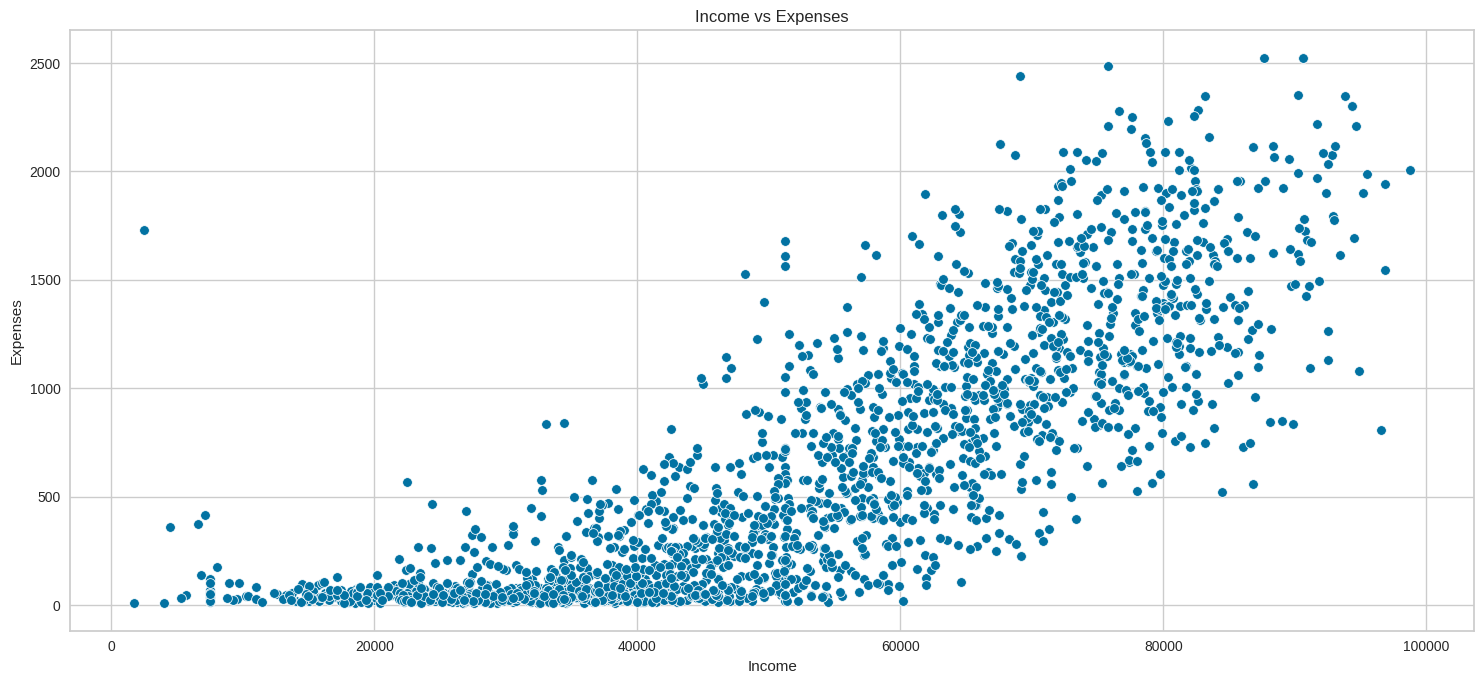

In [305]:
# Plot the scatter plot with Expenses and Income
plt.figure(figsize=(15, 7))
sns.scatterplot(x='Income', y='TotalExpenses', data=df)
plt.title('Income vs Expenses')
plt.xlabel('Income')
plt.ylabel('Expenses')
plt.tight_layout()
plt.show()

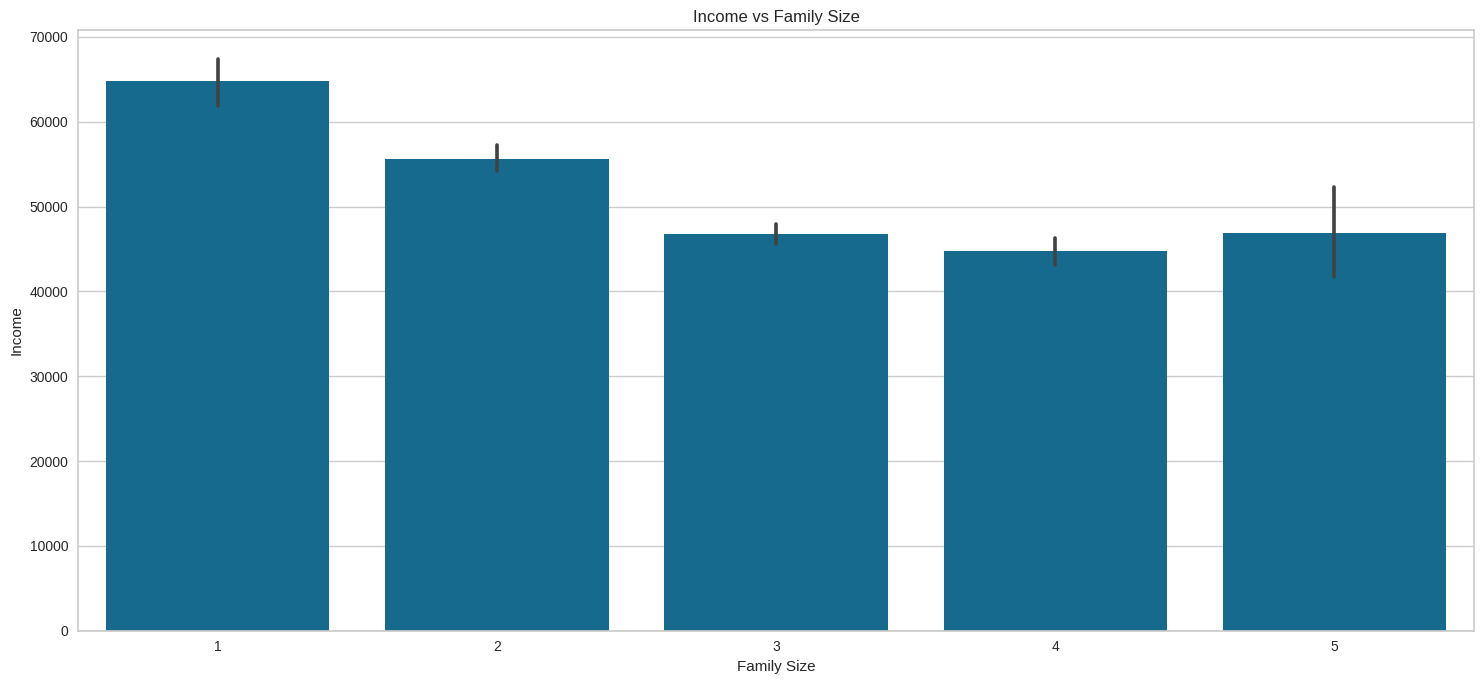

In [306]:
# Plot the bar plot with Family size and Income
plt.figure(figsize=(15, 7))
sns.barplot(x='FamilySize', y='Income', data=df)
plt.title('Income vs Family Size')
plt.xlabel('Family Size')
plt.ylabel('Income')
plt.tight_layout()
plt.show()

## **Important Insights from EDA and Data Preprocessing**

## **Data Preparation for Segmentation**

In [307]:
# Dropping all the irrelevant columns and storing in data_model
data_model = df.drop(
    columns=[
        'Education',
        'Marital_Status',
        'Income',
        'Complain',
        'Age',
        'Kids',
        'FamilySize'
    ],
    axis=1,
)

In [308]:
data_model.shape

(2222, 17)

In [309]:
data_model.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,DaysWithCompany,TotalExpenses,TotalNumPurchases,ExpensePerPurchase,TotalAcceptedOffers
0,58,635,88,546,172,88,88,3,8,10,4,7,1214,1617,25,64.680000,1
1,38,11,1,6,2,1,6,2,1,1,2,5,664,27,6,4.500000,0
2,26,426,49,127,111,21,42,1,8,2,10,4,863,776,21,36.952381,0
3,26,11,4,20,10,3,5,2,2,0,4,6,690,53,8,6.625000,0
4,94,173,43,118,46,27,15,5,5,3,6,5,712,422,19,22.210526,0


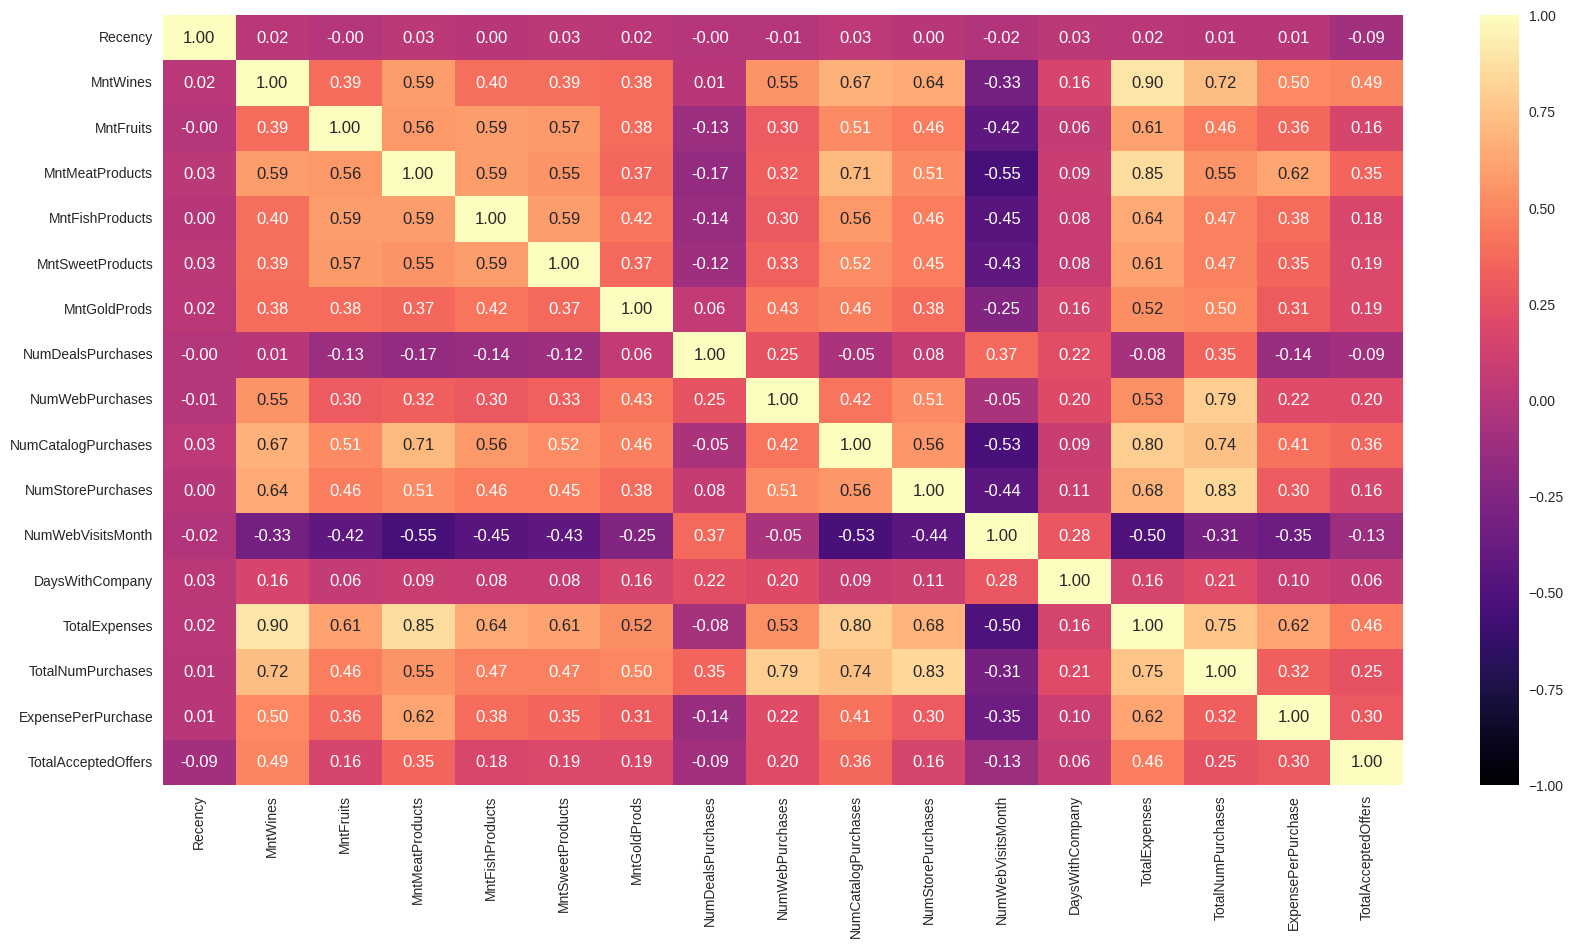

In [310]:
# Create the heatmap for data_model
plt.figure(figsize=(20, 10))
sns.heatmap(data=data_model.corr(), annot=True, cmap='magma', vmin=-1, vmax=1, fmt=".2f")
plt.show()

## **Applying T-SNE and PCA to the data to visualize the data distributed in 2 dimensions**

### **Applying T-SNE**

**Observation and Insights:**

### **Applying PCA**

**Observation and Insights:**

## **K-Means**

### **Applying KMeans on the PCA data and visualize the clusters**

### **Cluster Profiling**

**Observations and Insights:**

### **Describe the characteristics of each cluster**

**Summary of each cluster:**

## **K-Medoids**

### **Visualize the clusters using PCA**

### **Cluster Profiling**

**Observations and Insights:**

### **Characteristics of each cluster**

**Summary for each cluster:**

**Observations and Insights:**

## **Hierarchical Clustering**

- Find the Cophenetic correlation for different distances with different linkage methods.
- Create the dendrograms for different linkages
- Explore different linkages with each distance metric

### **Visualize the clusters using PCA**

### **Cluster Profiling**

**Observations and Insights:**

### **Characteristics of each cluster**

**Summary of each cluster:**

## **DBSCAN**

### **Apply DBSCAN for the best hyperparameter and visualize the clusters from PCA**

**Observations and Insights:**


### **Characteristics of each cluster**

**Summary of each cluster:**

## **Gaussian Mixture Model**

**Observations and Insights:**

### **Visualize the clusters using PCA**

### **Cluster Profiling**

**Observations and Insights:**


### **Characteristics of each cluster**

**Summary of each cluster:**

## **Conclusion and Recommendations**
